We have 8 csv files:

- Bullying_1: aggression_parsed_dataset.csv       (115864 rows × 5 columns)
- Bullying_2: attack_parsed_dataset.csv           (115864 rows × 5 columns) 
- Bullying_3: twitter_parsed_dataset.csv          (16851 rows × 5 columns) 
- Bullying_4: twitter_racism_parsed_dataset.csv   (13471 rows × 5 columns) 
- Bullying_5: twitter_sexism_parsed_dataset.csv   (14881 rows × 5 columns) 
- Bullying_6: youtube_parsed_dataset.csv          (3464 rows × 10 columns) 
- Bullying_7: toxicity_parsed_dataset.csv         (159686 rows × 5 columns) 
- Bullying_8: kaggle_parsed_dataset.csv           (8799 rows × 4 columns) 


https://www.kaggle.com/datasets/saurabhshahane/cyberbullying-dataset?select=aggression_parsed_dataset.csv

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import joblib

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import load_model

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)



In [2]:
#pip install --upgrade nltk

In [3]:
# Loading the data
sample_size = 1000
B = pd.read_csv("toxicity_parsed_dataset.csv", nrows=sample_size, index_col=0)

In [4]:
# Original dataframe
B

,Text,ed_label_0,ed_label_1,oh_label
index,,,,
0,This: :One can make an analogy in mathematical...,0.9,0.1,0
1,` :Clarification for you (and Zundark's righ...,1.0,0.0,0
2,Elected or Electoral? JHK,1.0,0.0,0
3,`This is such a fun entry. Devotchka I once...,1.0,0.0,0
4,Please relate the ozone hole to increases in c...,0.8,0.2,0
...,...,...,...,...
995,==Rhobite's lack of sincerity revealed== Rho...,0.8,0.2,0
996,` *That's an interesting thought. It is usefu...,1.0,0.0,0
997,==Please obtain a Wikipedia User ID== It wo...,1.0,0.0,0


In [5]:
# sample of a 'bullying text (1)'
B.loc[B["oh_label"]==1].sample()

,Text,ed_label_0,ed_label_1,oh_label
index,,,,
334,```Nazi filth`` is impolite `,0.2,0.8,1


In [6]:
B['Text'][661]

'i have a dick, its bigger than yours! hahaha'

In [7]:
# sample of a 'bullying text (0)'
B.loc[B["oh_label"]==0].sample()

,Text,ed_label_0,ed_label_1,oh_label
index,,,,
538,Could someone edit the article to explain ...,1.0,0.0,0


In [8]:
B['Text'][3]

"`This is such a fun entry.   Devotchka  I once had a coworker from Korea and not only couldn't she tell the difference between USA-English and British English, she had trouble telling the difference between different European languages.  (Kind of keeps things in perspective, eh?) -) :Not suprising. While I can easily tell the difference between French, German, Italian, Spanish, Dutch, etc., put me in a room with a Chinese, Japanese, Korean, Vietnamese and a Thai speaker and I probably couldn't tell the difference. (If I saw it written I'd probably have somewhat more luck though.)  SJK  Vietnamese has more syllable-final consonants than Japanese, I think you can tell them apart that way, maybe. Is this right? - Juuitchan  Someone suggested: ``Heath Robinson`` and ``Rube Goldberg`` as a vocabulary difference.  It's certainly an interesting parallel, but I don't think it really belongs here.  They were both artists with their own style, and both are known on both sides of the pond althou

### Text Preprocessing

In [9]:
### Text Preprocessing:
# Cleaning and preprocessing the text data. This involves tasks like removing stop words, handling emojis, 
# and converting text to lowercase.
# Tokenizing the text to convert it into a format suitable for machine learning algorithms.

In [10]:
# checking null values
B.isna().sum()

Text          0
ed_label_0    0
ed_label_1    0
oh_label      0
dtype: int64

In [11]:
# distribution of bullying vs. no-bullying content
B['oh_label'].value_counts()

oh_label
0    986
1     14
Name: count, dtype: int64

In [12]:
# Preprocessing the text. Cenverting to lower_case, removing any special characters/symbols and removing extra spaces.

def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'\W', ' ', text) # Remove special characters and symbols
    text = re.sub(r'\s+', ' ', text, flags=re.MULTILINE) # Remove extra spaces
    words = [word for word in text.split() if word.isalnum() and word.isalpha()] # Split the text into words and keep only alphanumeric words
    cleaned_text = ' '.join(words) # Join the words with a space
    return cleaned_text

In [13]:
# Apply the clean_text function to the "Text" column
B['Cleaned_Text'] = B['Text'].apply(clean_text)
B[['Cleaned_Text']]

,Cleaned_Text
index,
0,this one can make an analogy in mathematical t...
1,clarification for you and zundark s right i sh...
2,elected or electoral jhk
3,this is such a fun entry devotchka i once had ...
4,please relate the ozone hole to increases in c...
...,...
995,rhobite s lack of sincerity revealed rhobite g...
996,that s an interesting thought it is useful to ...
997,please obtain a wikipedia user id it would gre...


In [14]:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.data.path.append('/root/nltk_data/corpora/')

In [15]:
# Tokenizing and removing stopwords

def tokenizing_and_stopwords(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    text = " ".join(filtered_tokens)
    return text

In [16]:
# Apply the tokenizing_and_stopwords function to the "Cleaned_Text" column

B['ctns_Text'] = B['Cleaned_Text'].apply(tokenizing_and_stopwords)  
B[['ctns_Text']] #ctns_Text = cleaned, tokenized, no stopwords

,ctns_Text
index,
0,one make analogy mathematical terms envisionin...
1,clarification zundark right checked wikipedia ...
2,elected electoral jhk
3,fun entry devotchka coworker korea tell differ...
4,please relate ozone hole increases cancer prov...
...,...
995,rhobite lack sincerity revealed rhobite gets c...
996,interesting thought useful note though post di...
997,please obtain wikipedia user id would greatly ...


In [17]:
B['ctns_Text'][94]

'second thought instead provide new user setting allows user choose whether wikilinks displayed intended author literally linked trivial add code everyone would happy jan utc'

In [18]:
# lemmatization aims to reduce words to their base or root form.

def lemmatization_and_stopwords(text):
    if not text:
        return ""
    tokens = word_tokenize(text)
    clean_text = []
    lemmatizer = nltk.WordNetLemmatizer()
    for token in tokens:
        if token.lower() not in stopwords.words('english') and len(token) > 3:
            token = lemmatizer.lemmatize(token)
            clean_text.append(token)
    result_text = " ".join(clean_text)
    return result_text

In [19]:
# Apply lemmatization function to the "ctns_Text" column
B['lemm_text'] = B['ctns_Text'].apply(lemmatization_and_stopwords)
B[['lemm_text']]

,lemm_text
index,
0,make analogy mathematical term envisioning dis...
1,clarification zundark right checked wikipedia ...
2,elected electoral
3,entry devotchka coworker korea tell difference...
4,please relate ozone hole increase cancer provi...
...,...
995,rhobite lack sincerity revealed rhobite get cr...
996,interesting thought useful note though post di...
997,please obtain wikipedia user would greatly hel...


In [20]:
B['lemm_text'][57]

'know idea airy county tokerboy added county listed frederick county article'

In [21]:
# To show all the 'processed text' columns
B

,Text,ed_label_0,ed_label_1,oh_label,Cleaned_Text,ctns_Text,lemm_text
index,,,,,,,
0,This: :One can make an analogy in mathematical...,0.9,0.1,0,this one can make an analogy in mathematical t...,one make analogy mathematical terms envisionin...,make analogy mathematical term envisioning dis...
1,` :Clarification for you (and Zundark's righ...,1.0,0.0,0,clarification for you and zundark s right i sh...,clarification zundark right checked wikipedia ...,clarification zundark right checked wikipedia ...
2,Elected or Electoral? JHK,1.0,0.0,0,elected or electoral jhk,elected electoral jhk,elected electoral
3,`This is such a fun entry. Devotchka I once...,1.0,0.0,0,this is such a fun entry devotchka i once had ...,fun entry devotchka coworker korea tell differ...,entry devotchka coworker korea tell difference...
4,Please relate the ozone hole to increases in c...,0.8,0.2,0,please relate the ozone hole to increases in c...,please relate ozone hole increases cancer prov...,please relate ozone hole increase cancer provi...
...,...,...,...,...,...,...,...
995,==Rhobite's lack of sincerity revealed== Rho...,0.8,0.2,0,rhobite s lack of sincerity revealed rhobite g...,rhobite lack sincerity revealed rhobite gets c...,rhobite lack sincerity revealed rhobite get cr...
996,` *That's an interesting thought. It is usefu...,1.0,0.0,0,that s an interesting thought it is useful to ...,interesting thought useful note though post di...,interesting thought useful note though post di...
997,==Please obtain a Wikipedia User ID== It wo...,1.0,0.0,0,please obtain a wikipedia user id it would gre...,please obtain wikipedia user id would greatly ...,please obtain wikipedia user would greatly hel...


In [22]:
B['text_len'] = B['lemm_text'].apply(lambda text: len(text.split()))

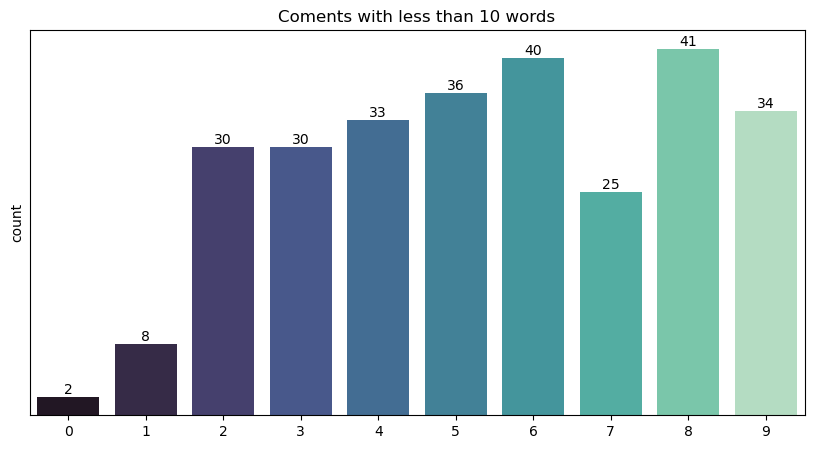

In [23]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='text_len', data=B[B['text_len']<10], palette='mako')
plt.title('Coments with less than 10 words', fontsize=12)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

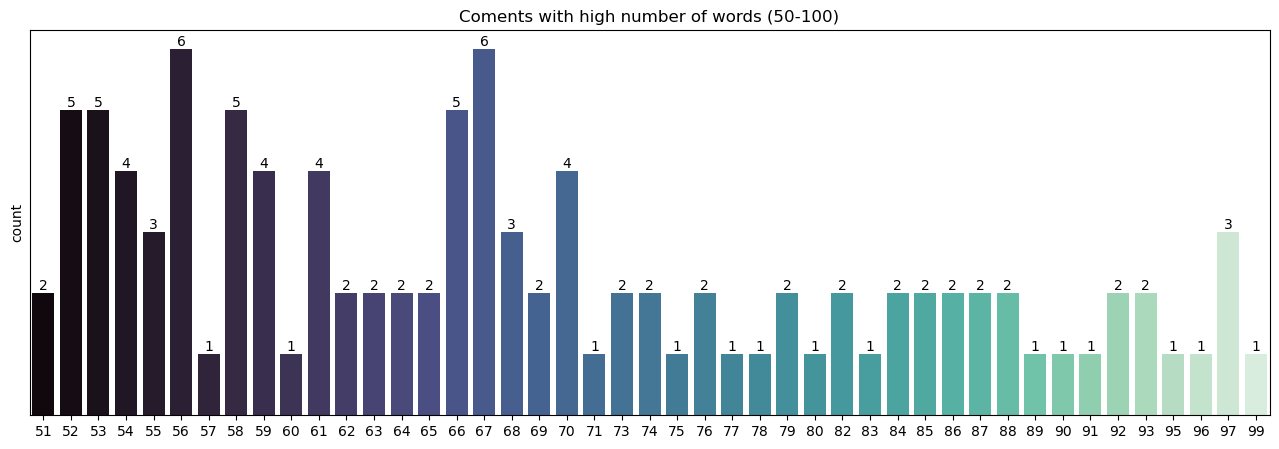

In [24]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=B[(B['text_len']<=100) & (B['text_len']>50)], palette='mako')
plt.title('Coments with high number of words (50-100)', fontsize=12)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [25]:
B.sort_values(by=["text_len"], ascending=False)

,Text,ed_label_0,ed_label_1,oh_label,Cleaned_Text,ctns_Text,lemm_text,text_len
index,,,,,,,,
863,"` ==66.185.85.80's rant== Presently, we are ...",1.0,0.0,0,s rant presently we are witnessing an open war...,rant presently witnessing open war croatian di...,rant presently witnessing open croatian dinari...,431
527,` (Ivo Banac)...A bit of nonteleological hist...,1.0,0.0,0,ivo banac a bit of nonteleological history one...,ivo banac bit nonteleological history one grea...,banac nonteleological history great problem un...,401
181,"Hi Eric, no. You are not in any way one of ...",1.0,0.0,0,hi eric no you are not in any way one of the p...,hi eric way one people talking got caught cros...,eric people talking caught crossfire made thin...,394
713,` == More discussion of changes == Here's a ...,1.0,0.0,0,more discussion of changes here s a few excerp...,discussion changes excerpts article like visit...,discussion change excerpt article like visit s...,382
20,` ===Announcement=== I have compared Helga's ...,1.0,0.0,0,announcement i have compared helga s original ...,announcement compared helga original version h...,announcement compared helga original version h...,369
...,...,...,...,...,...,...,...,...
632,:So far so good 8^) -,1.0,0.0,0,so far so good,far good,good,1
309,HA AH AHA HAHAHAHHAHAHAHHAHAH,1.0,0.0,0,ha ah aha hahahahhahahahhahah,ha ah aha hahahahhahahahhahah,hahahahhahahahhahah,1
657,Aha - found it . -,1.0,0.0,0,aha found it,aha found,found,1


In [26]:
B['text_len'].sum()

36080

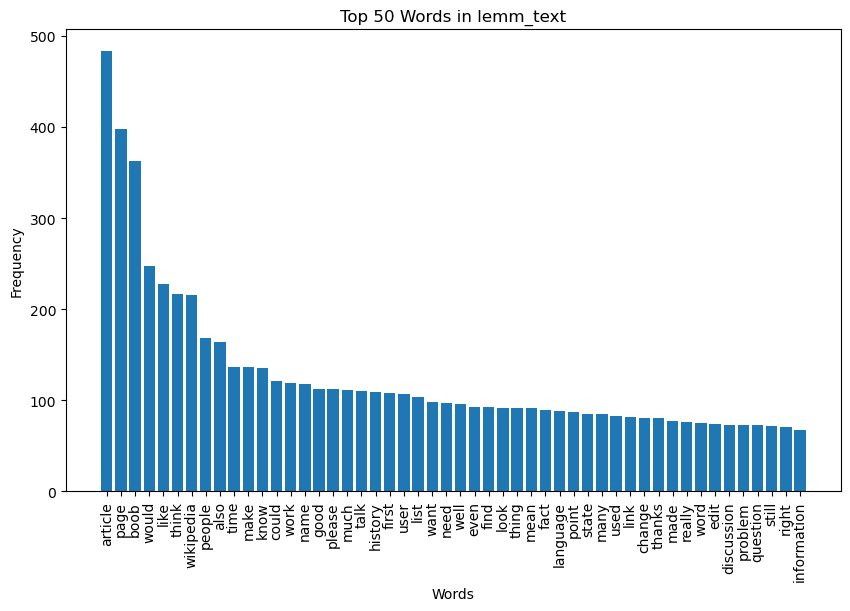

In [27]:
# top 10 words 
vectorizer = CountVectorizer()
word_matrix = vectorizer.fit_transform(B['lemm_text'])
words = vectorizer.get_feature_names_out()
word_frequencies = word_matrix.sum(axis=0)

word_freq_df = pd.DataFrame({'word': words, 'frequency': word_frequencies.tolist()[0]})
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

top_words_count = 50  
top_words = word_freq_df.head(top_words_count)

# Plot the top words
plt.figure(figsize=(10, 6))
plt.bar(top_words['word'], top_words['frequency'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_words_count} Words in lemm_text')
plt.xticks(rotation=90)
plt.show()

### Splitting the Dataset - X, y

In [28]:
X = B['lemm_text']
y = B[['oh_label']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the lengths of the resulting sets
print("Training set length:", len(X_train), len(y_train))
print("Testing set length:", len(X_test), len(y_test))

Training set length: 800 800
Testing set length: 200 200


### Feature Extraction

In [29]:
### Feature Extraction: Extracting relevant features from the text data. 
# Using word embeddingsb (Word2Vec, GloVe) to capture semantic relationships between words

In [30]:
sentences = B['lemm_text']
model = Word2Vec(sentences, vector_size=1000, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [31]:
X_train.fillna("", inplace=True)
X_test.fillna("", inplace=True)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have a consistent length
max_sequence_length = 500  # You can adjust this based on your data
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

print("Training set shape:", X_train_padded.shape, y_train.shape)
print("Testing set shape:", X_test_padded.shape, y_test.shape)

# Load pre-trained Word2Vec model
word2vec_model = Word2Vec.load("word2vec.model")

# Create an embedding matrix using Word2Vec
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, word2vec_model.vector_size))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Save the tokenizer
# joblib.dump(tokenizer, 'saved_tokenizer.joblib') 

Training set shape: (800, 500) (800, 1)
Testing set shape: (200, 500) (200, 1)


### Handling Imbalanced Data

In [32]:
### Handling Imbalanced Data for the training set (NOT DOING FOR THE WHOLE DATASET)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_sm, y_sm = smote.fit_resample(X_train_padded, y_train)

print("Original Training set shape:", X_train_padded.shape, y_train.shape)
print("Resampled Training set shape:", X_sm.shape, y_sm.shape)

Original Training set shape: (800, 500) (800, 1)
Resampled Training set shape: (1578, 500) (1578, 1)


#### MODEL - LOGISTIC REGRESSION

In [33]:
### Build the Model: Choose a suitable machine learning algorithm
# i.e. random forrest, logistic regression, support vector machines, or deep learning) and build the model.

In [34]:
# Create and train the Logistic Regression model

log_model = LogisticRegression()
log_model.fit(X_sm, y_sm)

# Predictions on the resampled training set
y_pred_train_log = log_model.predict(X_sm)

# Predictions on the test set
y_pred_test_log = log_model.predict(X_test_padded)  # Note: using X_test_padded for consistency with the original X_test

performance_log = pd.DataFrame({'Error_metric': ['Accuracy', 'Precision', 'Recall'],
                                'Train': [accuracy_score(y_sm, y_pred_train_log),
                                          precision_score(y_sm, y_pred_train_log, average='weighted'),  # Use 'weighted' for multi-label
                                          recall_score(y_sm, y_pred_train_log, average='weighted')],
                                'Test': [accuracy_score(y_test, y_pred_test_log),
                                         precision_score(y_test, y_pred_test_log, average='weighted'),
                                         recall_score(y_test, y_pred_test_log, average='weighted')]})

display(performance_log)

C:\Users\calum\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Error_metric,Train,Test
0,Accuracy,0.926489,0.780000
1,Precision,0.930071,0.972801
2,Recall,0.926489,0.780000


#### MODEL - RANDOM FOREST

In [35]:
rfc_ops = {
    "max_depth": 6,
    "min_samples_leaf": 20, ## by default 1 . This is the minimun number of data points per leaf
    "n_estimators": 100, ## number os trees in the forest
    "bootstrap": True, # default is true
    "oob_score": True, # out of bag can be retrieved
    "random_state": 42
}

clf = RandomForestClassifier(**rfc_ops)
clf.fit(X_sm, y_sm)

# Predictions on the resampled training set
y_pred_train_rfc = clf.predict(X_sm)

# Predictions on the test set
y_pred_test_rfc = clf.predict(X_test_padded)

performance_rfc = pd.DataFrame({'Error_metric': ['Accuracy', 'Precision', 'Recall'],
                                'Train': [accuracy_score(y_sm, y_pred_train_rfc),
                                          precision_score(y_sm, y_pred_train_rfc, average='weighted'),
                                          recall_score(y_sm, y_pred_train_rfc, average='weighted')],
                                'Test': [accuracy_score(y_test, y_pred_test_rfc),
                                         precision_score(y_test, y_pred_test_rfc, average='weighted'),
                                         recall_score(y_test, y_pred_test_rfc, average='weighted')]})

display(performance_rfc)

,Error_metric,Train,Test
0,Accuracy,0.960076,0.890000
1,Precision,0.962843,0.968674
2,Recall,0.960076,0.890000


#### MODEL - NAIVE BAYES

In [36]:
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_sm, y_sm)

# Predictions on the resampled training set
y_pred_train = naive_bayes_model.predict(X_sm)

# Predictions on the test set
y_pred_test = naive_bayes_model.predict(X_test_padded)

performance_naive_bayes = pd.DataFrame({'Error_metric': ['Accuracy', 'Precision', 'Recall'],
                                         'Train': [accuracy_score(y_sm, y_pred_train),
                                                   precision_score(y_sm, y_pred_train, average='weighted'),
                                                   recall_score(y_sm, y_pred_train, average='weighted')],
                                         'Test': [accuracy_score(y_test, y_pred_test),
                                                  precision_score(y_test, y_pred_test, average='weighted'),
                                                  recall_score(y_test, y_pred_test, average='weighted')]})


display(performance_naive_bayes)

print(classification_report(y_test, y_pred_test))

,Error_metric,Train,Test
0,Accuracy,0.701521,0.32500
1,Precision,0.789527,0.96983
2,Recall,0.701521,0.32500


              precision    recall  f1-score   support

           0       0.98      0.32      0.48       197
           1       0.01      0.67      0.03         3

    accuracy                           0.33       200
   macro avg       0.50      0.49      0.26       200
weighted avg       0.97      0.33      0.48       200



#### TENSORFLOW

In [37]:
### This one!

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=word2vec_model.vector_size,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False))

model.add(Flatten())


model.add(Dense(units=1, activation='sigmoid'))  # Binary classification, 1 output unit, sigmoid activation

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 1000)         6817000   
                                                                 
 flatten (Flatten)           (None, 500000)            0         
                                                                 
 dense (Dense)               (None, 1)                 500001    
                                                                 
Total params: 7317001 (27.91 MB)
Trainable params: 500001 (1.91 MB)
Non-trainable params: 6817000 (26.00 MB)
_________________________________________________________________


In [38]:
# Create callback to stop training process after getting >90% accuracy
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Assuming you are logging 'recall' and 'val_recall' during training
        train_recall = logs.get('recall', 0)
        val_recall = logs.get('val_recall', 0)
        if train_recall > 0.90 and val_recall > 0.90:
            self.model.stop_training = True
            print("\nThe recall of training and validation data has reached > 90%")

In [39]:
# No one-hot encoding needed for binary classification
callbacks = myCallback()

model.fit(X_train_padded, 
          y_train, epochs=10, 
          batch_size=64, 
          validation_data=(X_test_padded, y_test))

Epoch 1/10
13/13 [==============================] - 1s 61ms/step - loss: 0.6904 - accuracy: 0.9862 - val_loss: 0.6869 - val_accuracy: 0.9850
Epoch 2/10
13/13 [==============================] - 1s 49ms/step - loss: 0.6841 - accuracy: 0.9862 - val_loss: 0.6806 - val_accuracy: 0.9850
Epoch 3/10
13/13 [==============================] - 1s 42ms/step - loss: 0.6779 - accuracy: 0.9862 - val_loss: 0.6745 - val_accuracy: 0.9850
Epoch 4/10
13/13 [==============================] - 1s 43ms/step - loss: 0.6717 - accuracy: 0.9862 - val_loss: 0.6684 - val_accuracy: 0.9850
Epoch 5/10
13/13 [==============================] - 1s 61ms/step - loss: 0.6656 - accuracy: 0.9862 - val_loss: 0.6623 - val_accuracy: 0.9850
Epoch 6/10
13/13 [==============================] - 1s 43ms/step - loss: 0.6596 - accuracy: 0.9862 - val_loss: 0.6563 - val_accuracy: 0.9850
Epoch 7/10
13/13 [==============================] - 1s 43ms/step - loss: 0.6536 - accuracy: 0.9862 - val_loss: 0.6504 - val_accuracy: 0.9850
Epoch 8/10
13

In [40]:
evaluation_result = model.evaluate(X_test_padded, y_test)

# Print the evaluation result
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

7/7 [==============================] - 0s 14ms/step - loss: 0.6330 - accuracy: 0.9850
Test Loss: 0.6329529285430908
Test Accuracy: 0.9850000143051147


In [41]:
y_pred_train_prob = model.predict(X_train_padded)
y_pred_test_prob = model.predict(X_test_padded)

# Convert probabilities to class labels (using a threshold, e.g., 0.5)
y_pred_train = (y_pred_train_prob > 0.5).astype(int).reshape(-1)
y_pred_test = (y_pred_test_prob > 0.5).astype(int).reshape(-1)

# Calculate performance metrics
performance_tf = pd.DataFrame({'Error_metric': ['Accuracy', 'Precision', 'Recall'],
                             'Train': [accuracy_score(y_train, y_pred_train),
                                       precision_score(y_train, y_pred_train, average='weighted', zero_division=1),
                                       recall_score(y_train, y_pred_train, average='weighted', zero_division=1)],
                             'Test': [accuracy_score(y_test, y_pred_test),
                                      precision_score(y_test, y_pred_test, average='weighted', zero_division=1),
                                      recall_score(y_test, y_pred_test, average='weighted', zero_division=1)]})


display(performance_tf)

7/7 [==============================] - 0s 14ms/step


,Error_metric,Train,Test
0,Accuracy,0.986250,0.985000
1,Precision,0.986439,0.985225
2,Recall,0.986250,0.985000


In [42]:
# Save the model in SavedModel format
#model.save('tf2_model')

#### Comparing models

In [43]:
# Comparing the models

print("Combined Performance for All Models: \n")
print("LOGISTIC REGRESSION")
display(performance_log)
print("\nRANDOM FOREST")
display(performance_rfc)
print("\nNAIVE BAYES")
display(performance_naive_bayes)
print("\nTENSOR FLOW")
display(performance_tf)

Combined Performance for All Models: 

LOGISTIC REGRESSION


,Error_metric,Train,Test
0,Accuracy,0.926489,0.780000
1,Precision,0.930071,0.972801
2,Recall,0.926489,0.780000



RANDOM FOREST


,Error_metric,Train,Test
0,Accuracy,0.960076,0.890000
1,Precision,0.962843,0.968674
2,Recall,0.960076,0.890000



NAIVE BAYES


,Error_metric,Train,Test
0,Accuracy,0.701521,0.32500
1,Precision,0.789527,0.96983
2,Recall,0.701521,0.32500



TENSOR FLOW


,Error_metric,Train,Test
0,Accuracy,0.986250,0.985000
1,Precision,0.986439,0.985225
2,Recall,0.986250,0.985000


In [44]:
'''
LOGISTIC REGRESSION
Error_metric	Train	Test
0	Accuracy	0.926489	0.780000
1	Precision	0.930071	0.972801
2	Recall	0.926489	0.780000

RANDOM FOREST
Error_metric	Train	Test
0	Accuracy	0.960076	0.890000
1	Precision	0.962843	0.968674
2	Recall	0.960076	0.890000

NAIVE BAYES
Error_metric	Train	Test
0	Accuracy	0.701521	0.32500
1	Precision	0.789527	0.96983
2	Recall	0.701521	0.32500

TENSOR FLOW
Error_metric	Train	Test
0	Accuracy	0.998750	0.985000
1	Precision	0.998752	0.970225
2	Recall	0.998750	0.985000
'''

'\nLOGISTIC REGRESSION\nError_metric\tTrain\tTest\n0\tAccuracy\t0.926489\t0.780000\n1\tPrecision\t0.930071\t0.972801\n2\tRecall\t0.926489\t0.780000\n\nRANDOM FOREST\nError_metric\tTrain\tTest\n0\tAccuracy\t0.960076\t0.890000\n1\tPrecision\t0.962843\t0.968674\n2\tRecall\t0.960076\t0.890000\n\nNAIVE BAYES\nError_metric\tTrain\tTest\n0\tAccuracy\t0.701521\t0.32500\n1\tPrecision\t0.789527\t0.96983\n2\tRecall\t0.701521\t0.32500\n\nTENSOR FLOW\nError_metric\tTrain\tTest\n0\tAccuracy\t0.998750\t0.985000\n1\tPrecision\t0.998752\t0.970225\n2\tRecall\t0.998750\t0.985000\n'